<a href="https://colab.research.google.com/github/whdid502/stt_model_project/blob/feature_extraction/feature_extraction_mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# !pip install librosa
# !pip install torch
# !pip install torchaudio
# !pip install python_speech_features
# !pip install scipy
# !pip install fastai --user

In [101]:
# !pip3 install SpecAugment

In [102]:
# !pip3 install tensorflow

In [133]:
import wave
import librosa
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np
import argparse
import librosa.display
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import matplotlib
matplotlib.use('TKAgg')
from specAugment import spec_augment_tensorflow
from scipy.fftpack import dct

pmc2wav

In [104]:

def pcm2wav( pcm_file, wav_file, channels=1, bit_depth=16, sampling_rate=16000 ):

    # Check if the options are valid.
    if bit_depth % 8 != 0:
        raise ValueError("bit_depth "+str(bit_depth)+" must be a multiple of 8.")
        
    # Read the .pcm file as a binary file and store the data to pcm_data
    with open( pcm_file, 'rb') as opened_pcm_file:
        pcm_data = opened_pcm_file.read();
        
        obj2write = wave.open( wav_file, 'wb')
        obj2write.setnchannels( channels )
        obj2write.setsampwidth( bit_depth // 8 )
        obj2write.setframerate( sampling_rate )
        obj2write.writeframes( pcm_data )
        obj2write.close()

pcm2wav( '/content/drive/My Drive/googledrive/feature_test/KsponSpeech_000002.pcm', '/content/drive/My Drive/googledrive/feature_test/KsponSpeech_000002.wav', 1, 16, 16000 )

load audio(pcm)

In [131]:
def load_audio(audio_path, del_silence):
    try:
        signal = np.memmap(audio_path, dtype='h', mode='r').astype('float32')

        if del_silence:
            non_silence_indices = split(signal, top_db=30)
            signal = np.concatenate([signal[start:end] for start, end in non_silence_indices])

        return signal / 32767  # normalize audio

    except ValueError:
        logger.debug('ValueError in {0}'.format(audio_path))
        return None
    except RuntimeError:
        logger.debug('RuntimeError in {0}'.format(audio_path))
        return None
    except IOError:
        logger.debug('IOError in {0}'.format(audio_path))
        return None

In [123]:
data = load_audio('/content/drive/My Drive/googledrive/feature_test/KsponSpeech_000001.pcm', False)
data.shape

(50368,)

load audio

In [107]:
def load_audio_file(file_path):
    data = librosa.core.load(file_path,sr=22050)[0]
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 14, len(data)), data)
    plt.show()

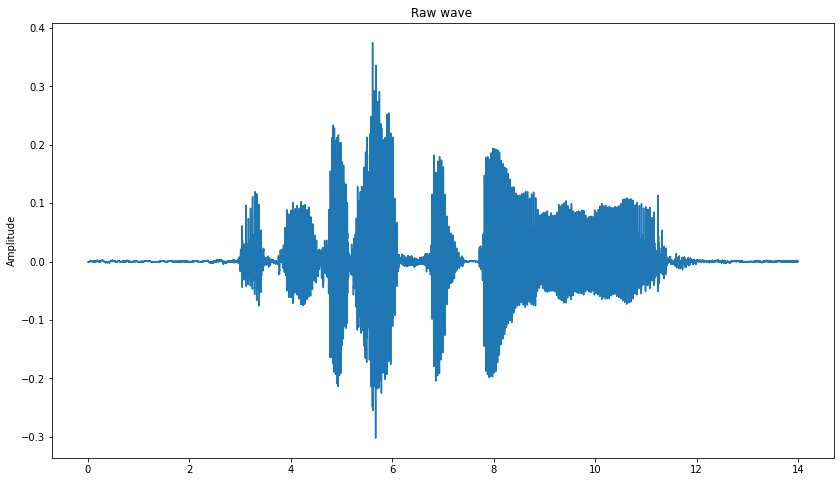

In [108]:
# data = load_audio_file("/content/drive/My Drive/googledrive/feature_test/KsponSpeech_000001.wav")
plot_time_series(data)

In [109]:
print(data)
print(data.shape)

[-9.7659230e-04 -9.7659230e-04 -8.8503677e-04 ... -9.1555528e-05
 -3.0518509e-05  1.2207404e-04]
(50368,)


In [110]:
ipd.Audio(data, rate=16000)

noise injector

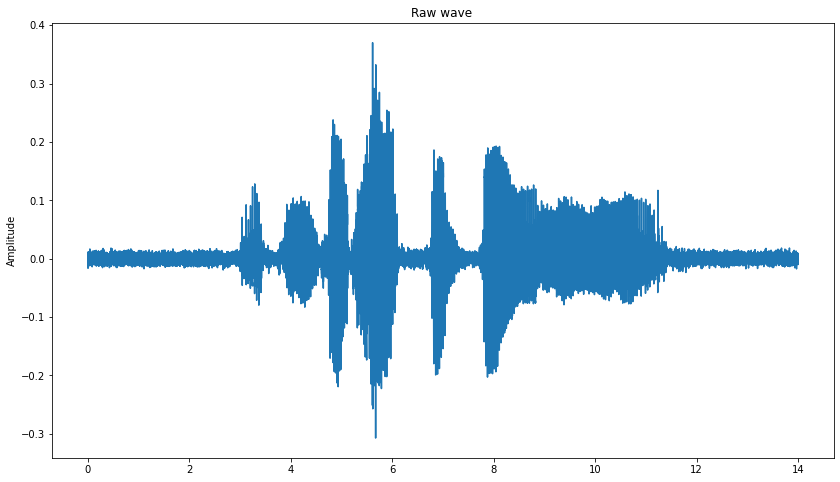

[-0.0059075  -0.01647347  0.00121584 ... -0.00746164 -0.00464907
  0.0009242 ]
(50368,)


In [111]:
wn = np.random.randn(len(data2))
data_wn = data2 + 0.005*wn
plot_time_series(data_wn)

print(data_wn)
print(data_wn.shape)
ipd.Audio(data_wn, rate=16000)

wav to mel_spec

In [117]:
# audio, sr = librosa.load('/content/drive/My Drive/googledrive/feature_test/KsponSpeech_000001.wav')

audio = data_wn
sr = 16000
print(audio)
print(sr)

[-0.0059075  -0.01647347  0.00121584 ... -0.00746164 -0.00464907
  0.0009242 ]
16000


In [145]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=256, hop_length=128, fmax=8000)

(256, 394)


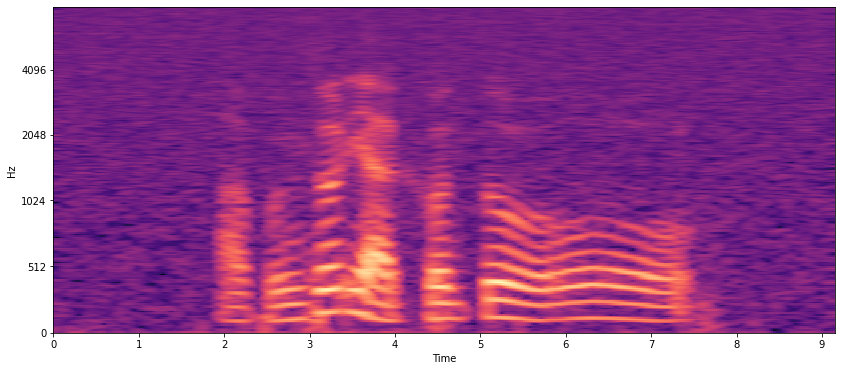

In [146]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), x_axis='time', y_axis='mel', fmax=8000)
print(mel_spectrogram.shape)

mel_spectogram add spec_augmentation

In [147]:
warped_masked_spectrogram = spec_augment_tensorflow.spec_augment(mel_spectrogram=mel_spectrogram)
warped_masked_spectrogram

array([[0.00332287, 0.00323585, 0.0031239 , ..., 0.00175857, 0.0020142 ,
        0.00210912],
       [0.00912869, 0.00851965, 0.00701849, ..., 0.00521785, 0.00588664,
        0.00636767],
       [0.01531645, 0.01444095, 0.01223338, ..., 0.00050969, 0.00074045,
        0.00086868],
       ...,
       [0.00041154, 0.0004277 , 0.00049867, ..., 0.0026122 , 0.00249518,
        0.00239959],
       [0.00047356, 0.00050653, 0.00061226, ..., 0.00323242, 0.00322767,
        0.00320287],
       [0.00156525, 0.00157159, 0.00159108, ..., 0.00337112, 0.00287631,
        0.00256121]], dtype=float32)

(256, 394)


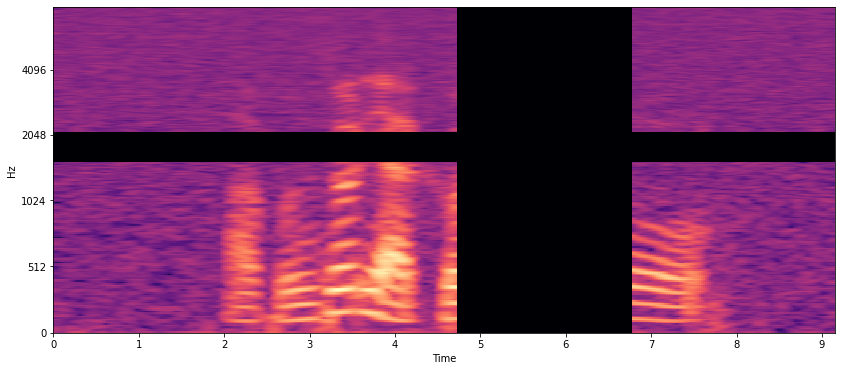

In [148]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(librosa.power_to_db(warped_masked_spectrogram, ref=np.max), x_axis='time', y_axis='mel', fmax=8000)
print(mel_spectrogram.shape)

In [149]:
num_ceps = 12
mfcc = dct(mel_spectrogram, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
print(mfcc.shape)
print(mfcc)


(256, 12)
[[ 0.34366026 -0.81421479 -0.59572684 ...  0.52911666  0.10328657
  -0.47878977]
 [ 0.29293439 -0.43518834 -0.45872422 ...  0.08493679  0.00769712
  -0.00680833]
 [ 0.11903144 -0.22912943 -0.28831825 ... -0.18700834 -0.09480456
   0.28107048]
 ...
 [ 0.00158789 -0.00342822  0.00282387 ...  0.00197316 -0.00262007
   0.00337635]
 [-0.0024015  -0.00447566  0.00256485 ... -0.00082319 -0.00493542
   0.00595363]
 [-0.00422006 -0.00177111  0.00252678 ...  0.00101412 -0.00412153
   0.00300992]]


(256, 12)


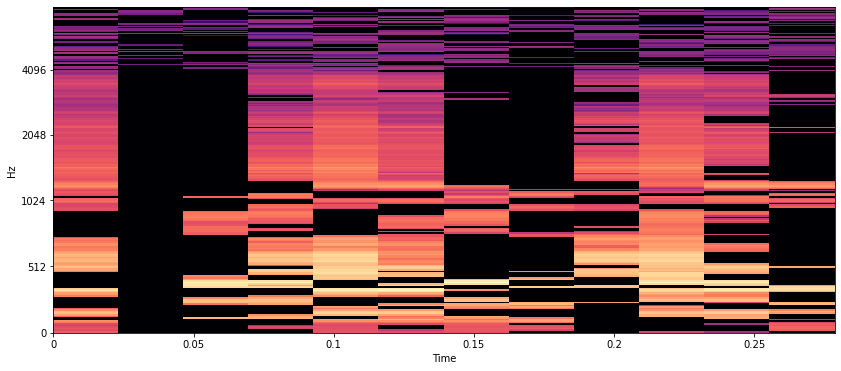

In [151]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(librosa.power_to_db(mfcc, ref=np.max), x_axis='time', y_axis='mel', fmax=8000)
print(mfcc.shape)